## Supervised Learning
## Project: Finding Donors for *CharityML*

## Getting Started

In this project, I employ several supervised algorithms of accurately model individuals' income using data collected from the 1994 U.S. Census. I select the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. The goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. 

----
## Exploring the Data
Load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


###  Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000.

In [2]:
# Total number of records
n_records = data.count()[0]
# Number of records where individual's income is more than $50,000
n_greater_50k = data.loc[data['income']!='<=50K'].count()[0]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data.loc[data['income']=='<=50K'].count()[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = round(n_greater_50k*100/ (n_greater_50k+n_at_most_50k),2)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

### Transforming Skewed Continuous Features
There are two features in the dataset with an unsual distribution: '`capital-gain'` and `'capital-loss'`. 
Apply logarithmic transformation to reduce skewness.  Values close to zero are set to a small amount.

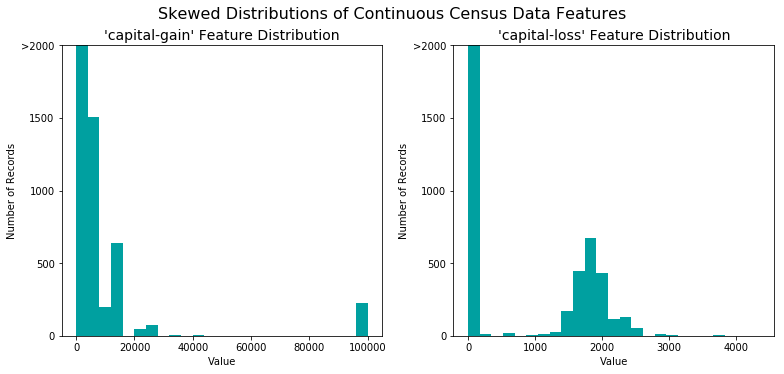

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

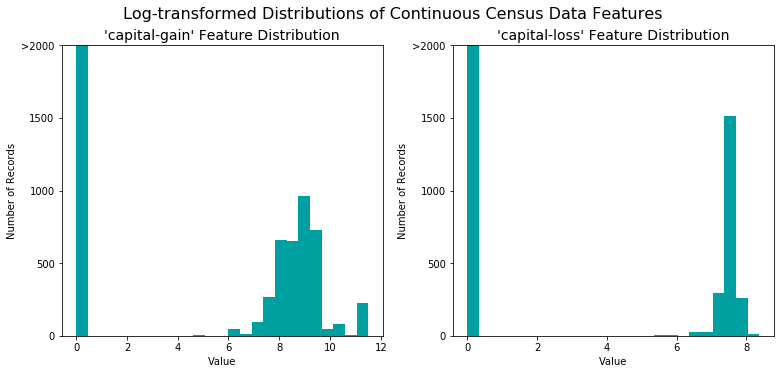

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
Transform numerical features onto a scale between 0 to 1

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Preprocessing

Convert textual features into categorical variables and convert outcome variable into a dummy variable with "<=50K" set to `0` and records with ">50K" set to `1`.

In [ ]:
#  One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
categorical_variables=['workclass', 'education_level','marital-status', 'occupation','relationship','race','sex','native-country']
#features_final = pd.DataFrame(features_log_minmax_transform)
#features_final=pd.concat([features_final,pd.get_dummies(data=features_final[categorical_variables],dummy_na=True)],axis=1)
#features_final=features_final.drop(categorical_variables, axis=1)
features_final = pd.get_dummies(features_log_minmax_transform)


#  Encode the 'income_raw' data to numerical values
income = (income_raw=='>50K')*1

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded)

### Shuffle and Split Data
Split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
Evaluate the model using accruacy, precision and recall.

### Naive Predictor Performace
Evaluate the performance of a model that always predicts that income is above 50k.

In [10]:

TP = np.sum(income) 
# Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

 #Calculate accuracy, precision and recall
accuracy = (TP+TN)/(FP+FN+TP+TN)
recall = TP/(TP+FP)
precision = TP/(TP+FN)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta=0.5
fscore = (1+beta**2)*precision*recall/(precision*beta**2+recall)

 #Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.6223]


I selected the Decision Tree, KNeighbors and Logistic Regression Models.

Logistic Regression Models can be used to predict purchasing decisions for consumer products.  One of the strengths is its speed even for large training datasets and numbers of features.  The algorithm is fast because the cost function is linearly separable, resulting in a smooth optimization problem that converges quickly via gradient-based methods.  It performs well when the size of the training data is large relative to the number of features, so that there is minimal overfitting.  The weakness of the model is that it imposes a functional form assumption on the data generating process for its mathematical convenience but does not correspond to a real-world interpretation.  The model will perform poorly with a large number of irrelevant features or mutually similar features.  Given the training dataset has 103 features, this model is a good candidate to provide an initial benchmark for prediction at a low computational cost.

The K-Nearest Neighbors algorithm can be used to provide entertainment recommendations.  The strength of KNN is its intuitive appeal.  A stakeholder with little or no training would can still understand the intuition behind making a prediction for one unit based on the behavior of "similar" units (of course the determination of what's considered "similar" will be subjective).  Thus, the KNN will perform welll when the distribution of the outcome conditional on the data is highly non-linear and the data scientist do not have any apriori information about the data generating process since the only information used in the algorithm is the similarity of data points to one another.  Conversely, the KNN imposes a high computational cost arising from the sheer number of permutations of "neighbors" to test.  The data scientist also faces the classic bias-variance tradeoff.  If he picks a small-k, in addition to the computational burden, the algorithm will be able to fit to the training data very well (i.e., low bias) but have little predictive ability in testing samples.  If he picks a large-k, then data points that are actually dissimilar will be grouped into neighbors resulting in inaccurate predictions.  I selected this model for the CharityML dataset because it represents the opposite extreme as the Logistic Regression.  The KNN can help answer the question, do people with similar demographic characteristics generally earn the same income?

The decision tree model can be applied to fraud detection (by people/companies).  The strength of the model is that there is a natural correspondence to human heuristics, i.e., how we think even when we are not formally applying computational theory.  Thus, the model will be effective when the data scientist can identify a natural dependency amongst the different features.  The weakness of decision trees is the computational cost that comes from the exponential relationship between the number of features and the possible permutations of trees that have to be tested.  The model will not work well when we do not have sufficient data points for all possible values of a particular feature.  When the decision tree branches into the feature with a sparse outcome, there is little information to train the model for further branches.  I selected this model because our knowledge of household demographics would identify a number of dependencies between features.  For example, a person's age and education level tend to be mechanically related.  For example, Seventeen year-olds can attain at most high school diploma and should not be married (hopefully).  So if we split the data based on age, then for the less than 22 year old branch, then perhaps it is no longer helpful to split on education level or marital status.  By augmenting the model with these insights, not only are we able to reduce computational time via the number of tree permutations to test but we can also improve the accruacy of our predictions.

In [24]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train.iloc[:sample_size,:], y_train[:sample_size])
    end = time() # Get end time
    
    #Calculate the training time
    results['train_time'] = end-start
        
    #  Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train.iloc[:300,:])
    end = time() # Get end time
    
    #Calculate the total prediction time
    results['pred_time'] = end-start
            
    #Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[0:300],predictions_train[0:300])
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    #Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[0:300],predictions_train[:300],beta=0.5)
        
    #Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Initial Model Evaluation
- Import the three supervised learning models discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.


LogisticRegression trained on 362 samples.
LogisticRegression trained on 3618 samples.
LogisticRegression trained on 36177 samples.
KNeighborsClassifier trained on 362 samples.
KNeighborsClassifier trained on 3618 samples.
KNeighborsClassifier trained on 36177 samples.
DecisionTreeClassifier trained on 362 samples.
DecisionTreeClassifier trained on 3618 samples.
DecisionTreeClassifier trained on 36177 samples.


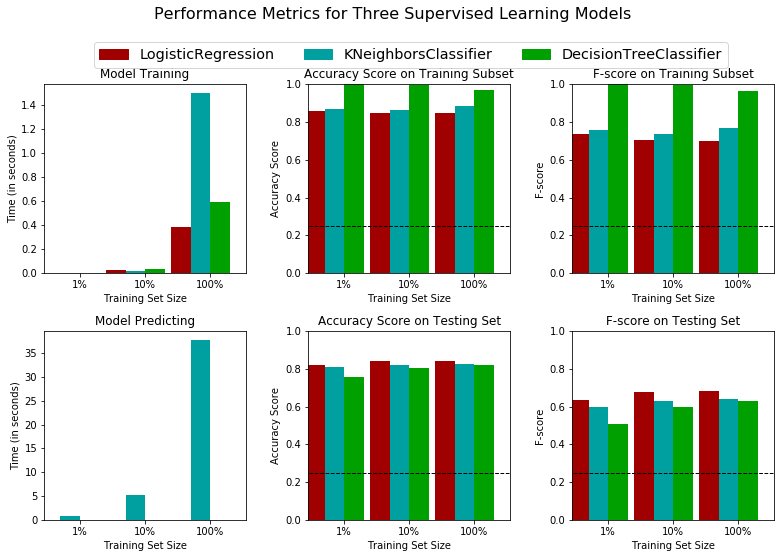

In [25]:
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# Initialize the three models
clf_A = LogisticRegression()
clf_B = KNeighborsClassifier()
clf_C = DecisionTreeClassifier()

#  Calculate the number of samples for 1%, 10%, and 100% of the training data

samples_100 = len(y_train)
samples_10 = int(round(0.1*samples_100,0))
samples_1 = int(round(0.01*samples_100,0))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
Choose from the three supervised learning models the *best* model to use on the student data. Perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

Unsurprisingly, the Logistic Regression performs the best in computing time while KNN is the slowest.  I had time to bake cupcakes while waiting for KNN to run on 100% of the sample.  It appears that decision trees is indistinguishable from logistic regression at the smaller samples and is only marginally slower for the full sample.  Logistic Regression and KNN perform almost equally well in their accruacy and F-score for the training data but they both lag behind decisions trees.  Logistic regression and KNN have less intuitive appeal because they treat all features as having a similar effect on the outcome.  For example, the assumption underlying those models is that whether or not a person is divorced and the amount of the capital gains in their portfolio affects their income in a simlar way.  In contrast, decision trees can accomodate the insight that a person's marital could have given rise to their capital gains or losses.  For all these reasons, I would recommend proceeding with the Decision Tree.

The model can be thought of a more scientifically precise version of our household guessing games such as 20 questions or charades.  Just like in 20 questions or charade, we think carefully about what we could ask to narrow down the unkown object (Is it a thing?  How many words?), the Decision Tree algorithm goes through each feature and considers which feature, if known, is most informative about the person's income level.  Having partitioned the data based on this highly informative feature, we usually require more information just like how the 20 question game doesn't usually end by the first question.  In particular, depending on the answer to the first question, the game player might adjust the subsequent questions to intelligently narrow down the object being guessed.  Similarly, the decision tree model will consider each of the sub-samples created by partitioning on the first important feature and search for the next most important feature for each respective sub-sample.  This procedure will be performed recusively until the model can make a fairly confident prediction about the person's income.

### Model Tuning
Use grid search (`GridSearchCV`) with one important parameter tuned with 3 different values.

In [9]:
#Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer,fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier

#Initialize the classifier
clf = DecisionTreeClassifier()

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'criterion': ['gini','entropy'], 'min_samples_split': [2,4,8,16,32,64],'min_samples_leaf': [2,4,8,16,32,64,128]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

#  Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_
# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8172
F-score on testing data: 0.6252

Optimized Model
------
Final accuracy score on the testing data: 0.8574
Final F-score on the testing data: 0.7239


### Final Model Evaluation


#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.8172      |      0.8574     |
| F-score        |       0.6252      |      0.7239     |


The optimized model improves on the unoptimized model in both accuracy and F-score.  It also performs significantly better than the naive predictor benchmark from Question 1. 

----
## Feature Importance

Determine which features provide the most predictive power.

 ### Feature Relevance Observation


I believe the five critical features, in the order of importance are (1) capital_gain (2) education_num, (3) race (4) age and (5) marital_status.  Capital_gain is a direct result of a person's income level.  High-income individuals tend to invest their wealth into stocks which accrue capital gains. In the U.S., we know that there are significant returns to education (measured in terms of income level).  Other features such as age, race and marital_status could capture sociological factors leading to income.

###  Extracting Feature Importance


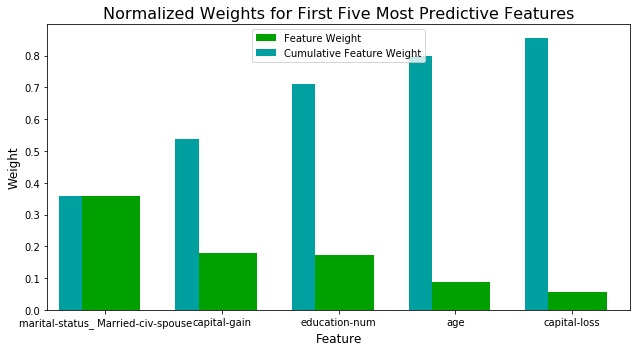

In [11]:
#Import a supervised learning model that has 'feature_importances_'

from sklearn.tree import DecisionTreeClassifier
# Train the supervised model on the training set using .fit(X_train, y_train)
model=best_clf.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

I had hypothesized that race could be an important feature but it is not confirmed by the data.  In contrast the data shows both capital gains and capital losses are important predictors of income.  The graph confirms the intuition that a person's education level and experience (as approximated by age) are critical to determining income levels.  It also confirms that a person's gains and losses from his wealth is strongly tied to his income.

### Feature Selection
Evaluate model performance by selecting only the five most import features.

In [12]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8574
F-score on testing data: 0.7239

Final Model trained on reduced data
------
Accuracy on testing data: 0.8519
F-score on testing data: 0.7104


###  Effects of Feature Selection

As expected, collapsing the number of features from 13 to 5 reduces the performance of the data.  However, the deterioration in accuracy and F-score is marginal.  Thus working with the reduced feature set might be prudent when computational time is scarce.